In [79]:
import tensorflow as tf

import numpy as np

import matplotlib.pyplot as plt 

import sklearn.datasets as skd 

In [80]:
numFeatures           = 2
numClusters           = 4
numSamples            = 5000
numIter               = 20      

In [81]:
centroids = tf.cast([[3, 5], [-3, 0], [5, -1], [0, 2]], tf.float64)

samples, labels = skd.make_blobs(n_samples = numSamples, centers = centroids, cluster_std = 0.9)

points    = samples
centroids = tf.convert_to_tensor(centroids)
labels    = tf.convert_to_tensor(labels)
samples   = tf.convert_to_tensor(samples)

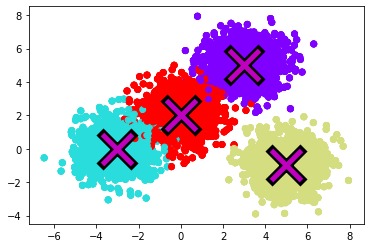

In [82]:
def plotClusters(samples, labels, centroids):

  colour = plt.cm.rainbow(np.linspace(0, 1, len(centroids)))

  for i, centroid in enumerate(centroids):

    plt.scatter(samples[:, 0], samples[:, 1], c = colour[labels])

    plt.plot(centroids[i, 0], centroids[i, 1], markersize = 35, marker = "x", color = 'k', mew = 10)
    plt.plot(centroids[i, 0], centroids[i, 1], markersize = 30, marker = "x", color = 'm', mew = 5)
    
  plt.show()

plotClusters(samples, labels, centroids)

In [83]:
# --- Initialize centroids as random sample elements
def initializeCentroids(samples, numClusters, numSamples):
    # --- https://www.tensorflow.org/api_docs/python/tf/random/shuffle
    randomIndices     = tf.random.shuffle(tf.range(0, numSamples))
    # --- https://www.tensorflow.org/api_docs/python/tf/slice
    centroidIndices   = tf.slice(randomIndices, begin = [0, ], size = [numClusters, ])
    # --- https://www.tensorflow.org/api_docs/python/tf/gather
    initialCentroids  = tf.gather(samples, centroidIndices)
    return initialCentroids

In [84]:
# --- Finds the nearest centroid for each sample
def assign2NearestCentroid(samples, centroids):

    # --- samples is (numSamples, 2) 
    # --- https://www.tensorflow.org/api_docs/python/tf/expand_dims
    # --- expandedSamples is (1, numSamples, 2) 
    expandedSamples   = tf.expand_dims(samples, 0)
    # --- centroids is (numClusters, 2)
    # --- expandedCentroids is (numClusters, 1, 2)
    expandedCentroids = tf.expand_dims(centroids, 1)
    # --- distances is (numClusters, numSamples) and contains, for each sample (column), the distances from all the cluster centroids
    #     tf.subtract automatically creates a meshgrid
    distances         = tf.reduce_sum(tf.square(tf.subtract(expandedSamples, expandedCentroids)), 2)
    # --- nearestIndices is (numSamples, ) and contains, for each sample, the index of the nearest centroid
    nearestIndices    = tf.argmin(distances, 0)
    return nearestIndices

In [85]:
# --- Updates the centroids to be the mean of all samples associated with the corresponding cluster.
def updateCentroids(samples, nearestIndices, numClusters):
    nearestIndices  = tf.cast(nearestIndices, tf.int32)
    # --- https://www.tensorflow.org/api_docs/python/tf/dynamic_partition
    # --- partitions is a list of numClusters tensor arrays organized according to the nearestIndices
    partitions      = tf.dynamic_partition(samples, nearestIndices, numClusters)
    # --- tf.reduce_mean(partition, 0) is a tensor of shape [2]
    # --- tf.expand_dims(tf.reduce_mean(partition, 0), 0) is a tensor of shape [1, 2]
    # --- newCentroids is a tensor of shape [4, 2]
    newCentroids    = tf.concat([tf.expand_dims(tf.reduce_mean(partition, 0), 0) for partition in partitions], 0)
    return newCentroids

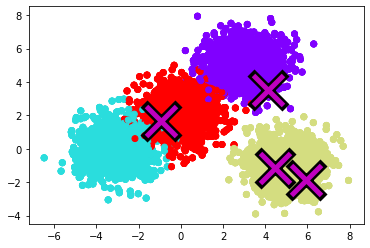

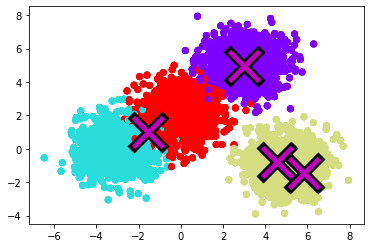

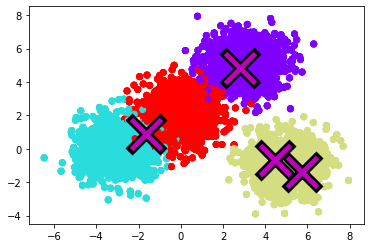

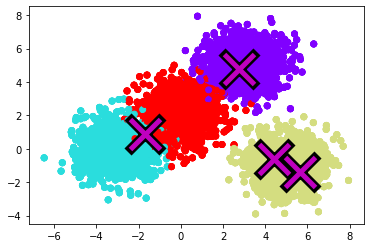

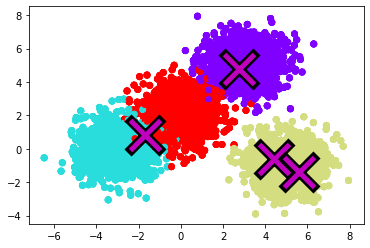

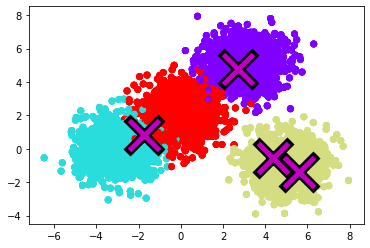

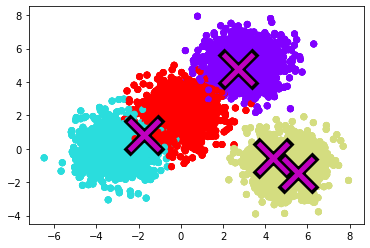

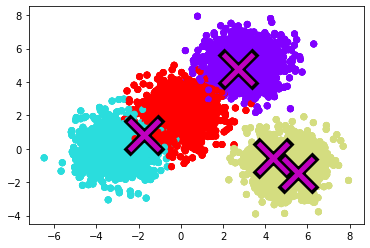

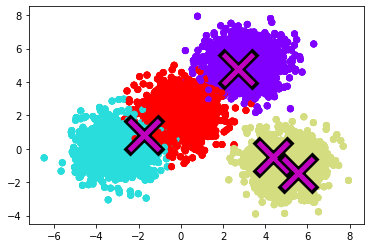

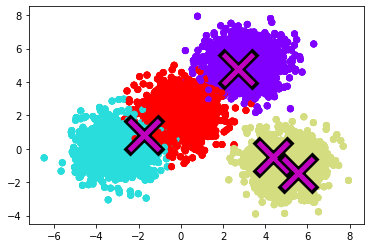

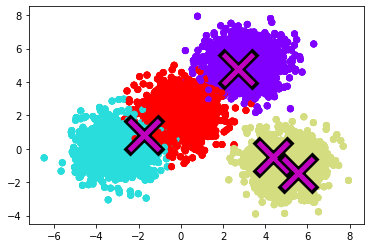

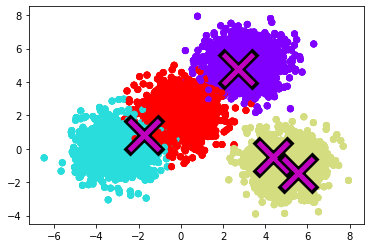

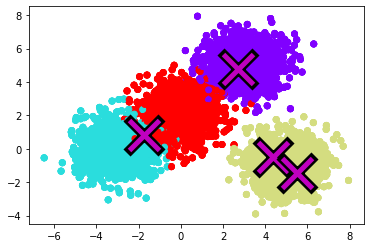

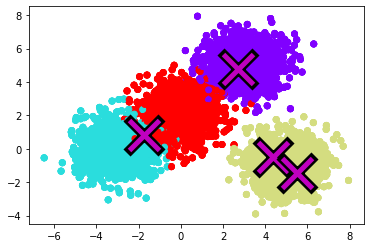

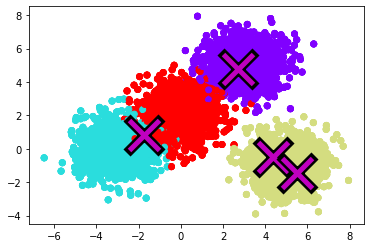

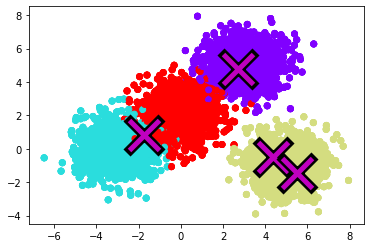

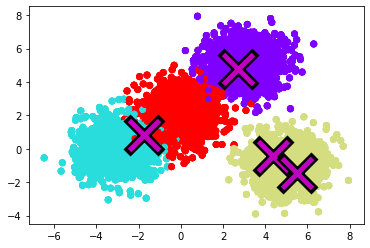

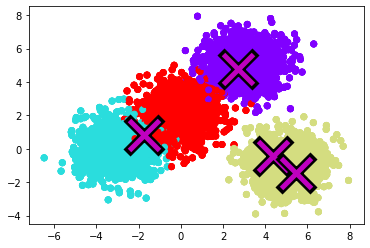

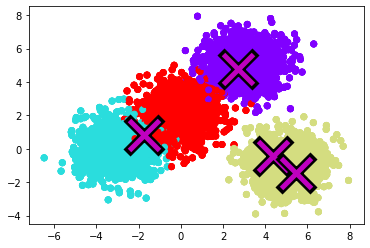

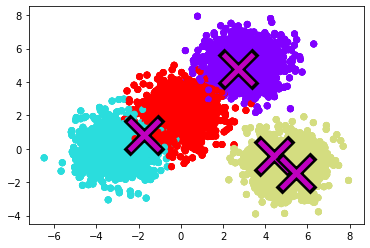

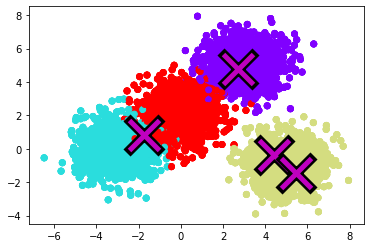

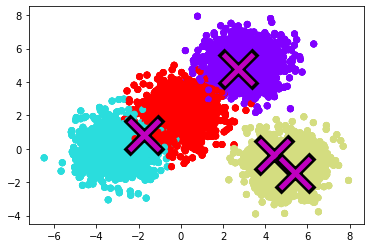

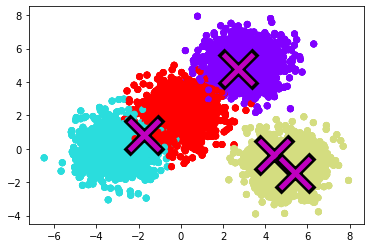

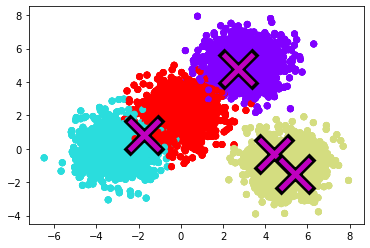

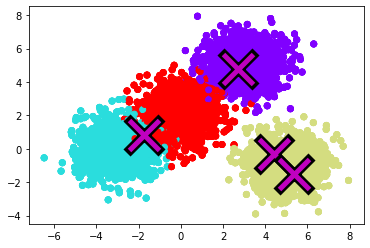

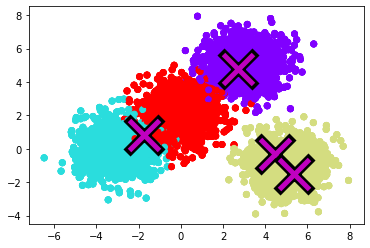

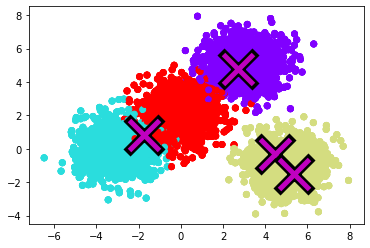

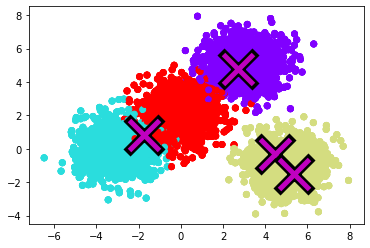

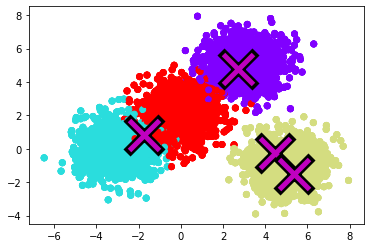

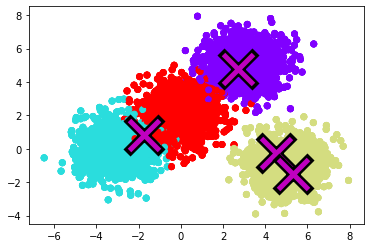

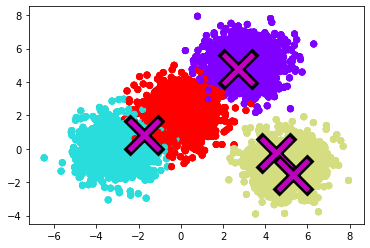

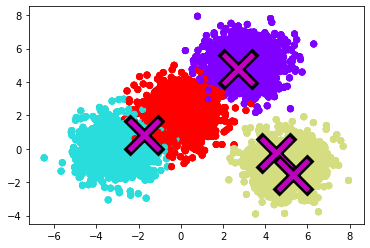

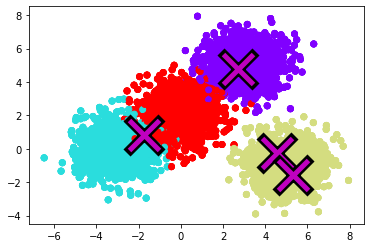

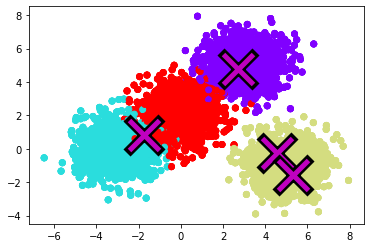

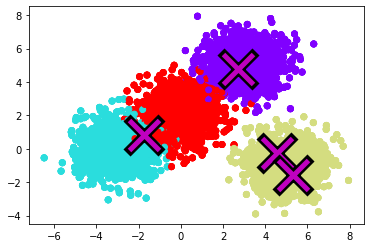

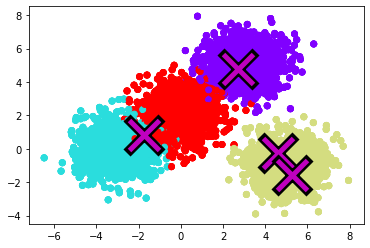

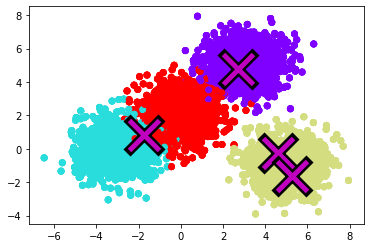

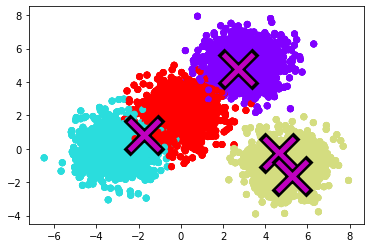

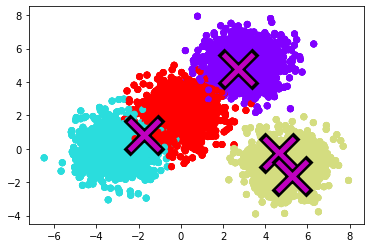

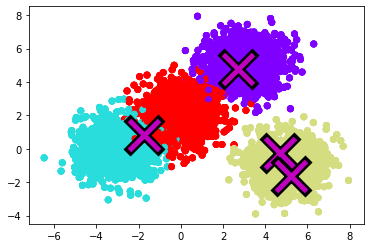

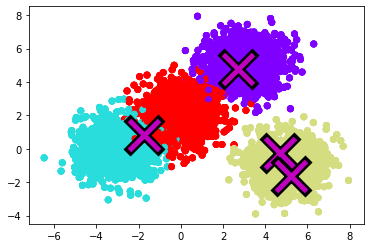

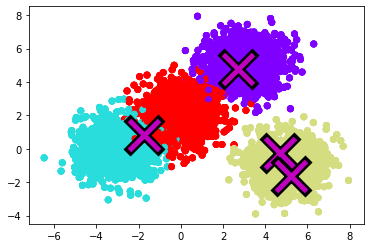

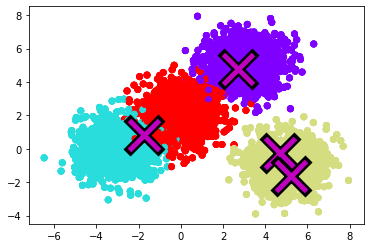

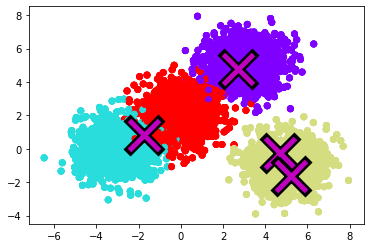

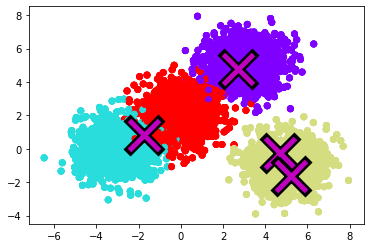

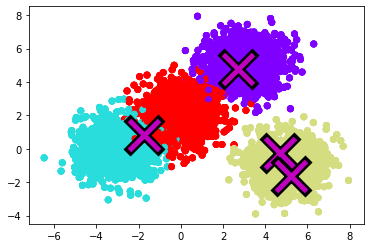

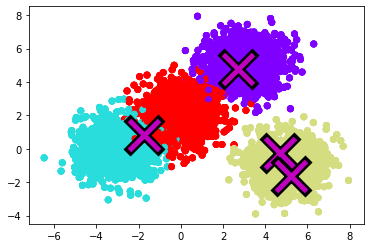

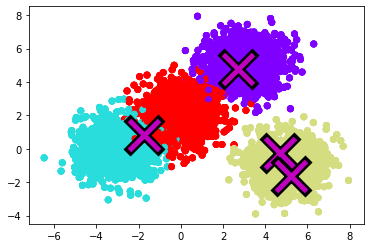

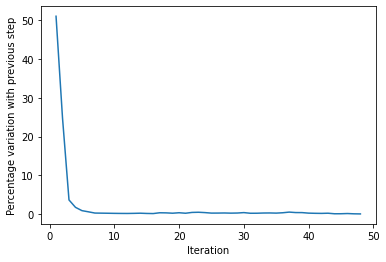

In [86]:
updateNorm    = float('inf') 

oldCentroids  = initializeCentroids(samples, numClusters, numSamples)

func          = np.empty((1, ), dtype = np.float64)
func[0]       = np.infty

while (updateNorm > 1e-4):

  nearestIndices      = assign2NearestCentroid(samples, oldCentroids)
  newCentroids        = updateCentroids(samples, nearestIndices, numClusters)
  updateNorm          = tf.sqrt(tf.reduce_sum(tf.square(newCentroids - oldCentroids)) / tf.reduce_sum(tf.square(centroids)))
  oldCentroids        = newCentroids
  plotClusters(samples, labels, newCentroids)

  updateNorm          = np.reshape(updateNorm.numpy(), (1, ))
  func                = np.append(func, updateNorm, axis = 0)

plt.plot(100. * func)
plt.xlabel('Iteration')
plt.ylabel('Percentage variation with previous step')
plt.show()

Output streaming troncato alle ultime 5000 righe.
point: [1.13750507 3.10667148] is in cluster 1 centered at [0.01465717 2.057141  ]
point: [2.58650577 3.43787511] is in cluster 2 centered at [2.9987895 5.0341296]
point: [2.52102034 3.56063491] is in cluster 2 centered at [2.9987895 5.0341296]
point: [-3.96003568  1.80469153] is in cluster 3 centered at [-3.0019898  -0.02775172]
point: [3.687725   5.96441958] is in cluster 2 centered at [2.9987895 5.0341296]
point: [ 5.33299791 -2.59169205] is in cluster 0 centered at [ 4.9971356 -0.9897613]
point: [-5.67160403 -1.33744161] is in cluster 3 centered at [-3.0019898  -0.02775172]
point: [1.92963756 5.97579817] is in cluster 2 centered at [2.9987895 5.0341296]
point: [1.99457744 3.93981475] is in cluster 2 centered at [2.9987895 5.0341296]
point: [-3.23739336 -0.75021386] is in cluster 3 centered at [-3.0019898  -0.02775172]
point: [-1.87534155  0.82673761] is in cluster 3 centered at [-3.0019898  -0.02775172]
point: [-1.01120544  1.748093

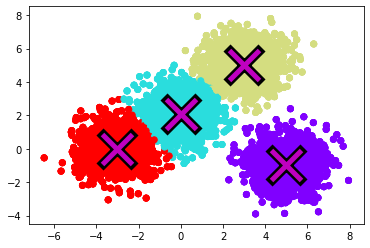

In [87]:
def input_fn():
  return tf.compat.v1.train.limit_epochs(tf.convert_to_tensor(points, dtype = tf.float32), num_epochs = 1)

kmeans = tf.compat.v1.estimator.experimental.KMeans(num_clusters = numClusters, use_mini_batch = False)

# --- Train
previousCenters = None
for _ in range(numIter):
  kmeans.train(input_fn)
  clusterCenters = kmeans.cluster_centers()
  if previousCenters is not None:
    print('Cluster centers variation:', clusterCenters - previousCenters)
  previousCenters = clusterCenters
  print('Algorithm score:', kmeans.score(input_fn))
print('Cluster centers:', clusterCenters)

# --- Map the database points to their clusters
clusterLabels = list(kmeans.predict_cluster_index(input_fn))
for i, point in enumerate(points):
  clusterIndex  = clusterLabels[i]
  center        = clusterCenters[clusterIndex]
  print('point:', point, 'is in cluster', clusterIndex, 'centered at', center)

plotClusters(samples, clusterLabels, clusterCenters)